# Fortune 500, demo av ett dataset
<br>
Vi undersöker hur den historiska omsättningen och vinsten har sett ut i USA med data taget från företaget Fortune 500.
<br>
Fortune 500 är en årlig lista sammanställd och publicerad av tidskriften Fortune som rankar 500 av de största företagen i USA efter totala intäkter för sina respektive räkenskapsår. Listan inkluderar offentliga företag, tillsammans med privatägda företag för vilka intäkter är offentligt tillgängliga.
Mer info om Fortune 500 hittar du på Wikipedia (https://en.wikipedia.org/wiki/Fortune_500)

In [4]:
# line magic to capture Matplotlib plots and render them in the cell output. 
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(style="darkgrid")

In [5]:
# Källa för fortune500.csv kan hämtas som csv-fil från https://s3.amazonaws.com/dq-blog-files/fortune500.csv
df = pd.read_csv('fortune500.csv')

Kolla innehåll och kvalitet på datan

In [6]:
df.head()

,Year,Rank,Company,Revenue (in millions),Profit (in millions)
0,1955,1,General Motors,9823.5,806
1,1955,2,Exxon Mobil,5661.4,584.8
2,1955,3,U.S. Steel,3250.4,195.4
3,1955,4,General Electric,2959.1,212.6
4,1955,5,Esmark,2510.8,19.1


In [7]:
df.tail()

,Year,Rank,Company,Revenue (in millions),Profit (in millions)
25495,2005,496,Wm. Wrigley Jr.,3648.6,493
25496,2005,497,Peabody Energy,3631.6,175.4
25497,2005,498,Wendy's International,3630.4,57.8
25498,2005,499,Kindred Healthcare,3616.6,70.6
25499,2005,500,Cincinnati Financial,3614.0,584


### Wrangling

In [8]:
# Renaming columns later reference.
df.columns = ['year', 'rank', 'company', 'revenue', 'profit']

In [9]:
len(df)

25500

In [10]:
df.dtypes

year         int64
rank         int64
company     object
revenue    float64
profit      object
dtype: object

In [11]:
# Q: How cohesive is the dataset? dtypes is object instead of float64.
# Q: profit must be int or preferably float - what does it look like?
# Using regexpr, Show everything except numbers 0-9.
non_numberic_profits = df.profit.str.contains('[^0-9.-]')
df.loc[non_numberic_profits].head()

,year,rank,company,revenue,profit
228,1955,229,Norton,135.0,N.A.
290,1955,291,Schlitz Brewing,100.0,N.A.
294,1955,295,Pacific Vegetable Oil,97.9,N.A.
296,1955,297,Liebmann Breweries,96.0,N.A.
352,1955,353,Minneapolis-Moline,77.4,N.A.


In [12]:
set(df.profit[non_numberic_profits])

{'N.A.'}

In [13]:
# OK, only 'N.A.' above - no other fuzz.
# Q: How many values are missing?
len(df.profit[non_numberic_profits])

369

Quality comment:
369 Is a small fraction of the data set. Not completely inconsequential but around 1.5%.
If N.A. are roughly uniformly distributed over the years, the easiest solution would be to remove them

<br>
Q: How is the distribution of fuzz values?

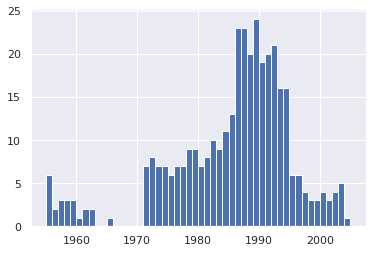

In [14]:
bin_sizes, _, _ = plt.hist(df.year[non_numberic_profits], bins=range(1955, 2006))

A: Distribution: is
The most invalid values in a single year is fewer than 25, and there are 500 data points per year, so removing these values would account for less than 4% of the data for the worst years.
the missing values has a peak in the 1990's but for this purposes it is acceptable to just remove these rows.

In [15]:
df = df.loc[~non_numberic_profits]
df.profit = df.profit.apply(pd.to_numeric)

In [16]:
len(df)

25131

In [17]:
df.dtypes

year         int64
rank         int64
company     object
revenue    float64
profit     float64
dtype: object

<br>
Quality is OK:<br>
25151 datapoints and profit is now float64

### Plotting med matplotlib

In [18]:
group_by_year = df.loc[:, ['year', 'revenue', 'profit']].groupby('year')
avgs = group_by_year.mean()
x = avgs.index
y1 = avgs.profit
def plot(x, y, ax, title, y_label):
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.plot(x, y)
    ax.margins(x=0, y=0)

### Vinst 1955 till 2005

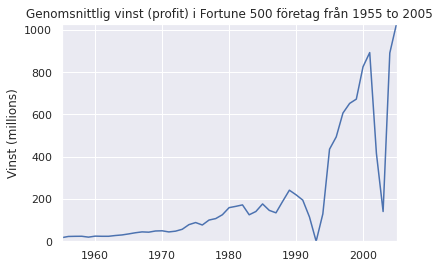

In [19]:
fig, ax = plt.subplots()
plot(x, y1, ax, 'Genomsnittlig vinst (profit) i Fortune 500 företag från 1955 to 2005', 'Vinst (millions)')

Vi ser att dengenomsnittliga vinsten ser ut som en exponentiell funktion, rejäl hicka med några stora nedgångar. 
<br>
De motsvarar lågkonjunkturen som fanns i början på 1990-talet och dotcom-bubblan åren efter millenieskiftet.
<br>

Q: Men hur kommer det sig att vinsterna återhämtade sig till ännu högre nivåer efter varje lågkonjunktur?
S: Kanske kan intäkterna berätta mer.

### Intäkter 1955 till 2005

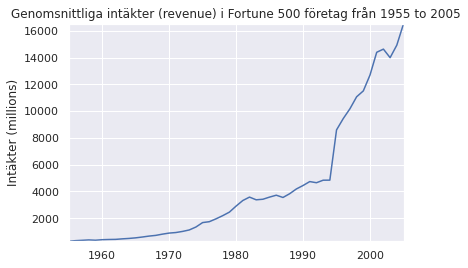

In [22]:
y2 = avgs.revenue
fig, ax = plt.subplots()
#plot(x, y2, ax, 'Increase in mean Fortune 500 company revenues from 1955 to 2005', 'Revenue (millions)')
plot(x, y2, ax, 'Genomsnittliga intäkter (revenue) i Fortune 500 företag från 1955 to 2005', 'Intäkter (millions)')

### Intäkter i detalj

Historiskt kan vi fortfarande se hack i intäktena - men itäkterna drabbades inte lika hårt.
<br>
Vi koller på en plott med +/- standardavvikelser för att få ett mer tydligt scenario.

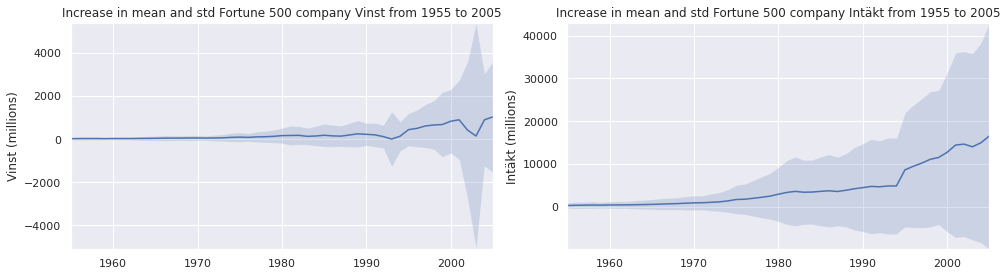

In [24]:

def plot_with_std(x, y, stds, ax, title, y_label):
    ax.fill_between(x, y - stds, y + stds, alpha=0.2)    # fill_between är skuggan.
    plot(x, y, ax, title, y_label)
fig, (ax1, ax2) = plt.subplots(ncols=2)
title = 'Increase in mean and std Fortune 500 company %s from 1955 to 2005'
stds1 = group_by_year.std().profit.values
stds2 = group_by_year.std().revenue.values
plot_with_std(x, y1.values, stds1, ax1, title % 'Vinst', 'Vinst (millions)')
plot_with_std(x, y2.values, stds2, ax2, title % 'Intäkt', 'Intäkt (millions)')
fig.set_size_inches(14, 4)
fig.tight_layout()

Det är stora standardavvikelser.
<br>
Vi ser ertt stort spann där vissa Fortune 500-företag tjänar miljarder medan andra förlorar miljarder, och vi ser också att risken att gå +/- har har ökat, samtidigt som vinsterna  har ökat under åren.

Q: Varför är det på detta sätt?
R: Kanske presterar vissa företag bättre än andra; är vinsterna för de översta 10 % mer eller mindre flyktiga än de lägsta 10 %?

Detta är något man kan titta.

Vinst och intäkt wikipedia (länka)
